In [1]:
from datetime import datetime
from sklearn.metrics import accuracy_score

from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import Vectorizer
from sklearn.model_selection import cross_val_score
 
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
reviewContent = pd.read_table("/home/drallab/datamining/YelpZip/reviewContent",names=["user_id","name","date","review"])
df_review = pd.DataFrame(reviewContent)

metadata = pd.read_table("/home/drallab/datamining/YelpZip/metadata",names=["user_id", "prod_id", "rating", "label", "date"])
df_metadata = pd.DataFrame(metadata)

#reviewGraph = pd.read_table("reviewGraph",names=["user_id","name","rating1"])#,names=["user_id", "prod_id", "rating", "label", "date"])
#df_reviewGraph = pd.DataFrame(reviewGraph)

combine = pd.concat([df_review,df_metadata],axis=1,join="inner")#, join_axes=[df_reviewGraph.user_id])
combine = combine.dropna()

train = combine[["label","review"]] # add date later
train.head()

#len(train[train["label"]==-1])/
#len(train)

/home/drallab/.conda/envs/myenv/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.
/home/drallab/.conda/envs/myenv/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


,label,review
0,-1,"Drinks were bad, the hot chocolate was watered..."
1,-1,This was the worst experience I've ever had a ...
2,-1,This is located on the site of the old Spruce ...
3,-1,I enjoyed coffee and breakfast twice at Toast ...
4,-1,I love Toast! The food choices are fantastic -...


In [3]:
# Make duplicates of negative samples to balance the data set
train1 = pd.concat([train[train["label"]==-1],train],axis=0)
train2 = pd.concat([train[train["label"]==-1],train1],axis=0)
train3 = pd.concat([train[train["label"]==-1],train2],axis=0)
#train4 = pd.concat([train[train["label"]==-1],train3],axis=0)
balanced_train = pd.concat([train[train["label"]==-1],train3],axis=0)

# Convulotional Neural Networks

In [4]:
# a list contains each review as a list 
balanced_texts = []
balanced_labels = []

for i in range(len(train)):
    balanced_texts.append(train.iloc[i,1])
    balanced_labels.append(train.iloc[i,0])

In [7]:
#choose the first 20000 common words and set vector size as 500
tokenizer = Tokenizer(num_words=20000)#20000
tokenizer.fit_on_texts(balanced_texts)
sequences = tokenizer.texts_to_sequences(balanced_texts)
data = pad_sequences(sequences, maxlen=500)#300

In [8]:
# build model and add layers
model = Sequential()
model.add(Embedding(20000, 128, input_length=500))#20000 300
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.array(balanced_labels), test_size=0.3)

In [ ]:
# fit model
model.fit(data, np.array(balanced_labels), validation_split=0.4, batch_size=200, epochs=150)
#model.fit(X_train,y_train,batch_size=200)

Train on 365074 samples, validate on 243384 samples
Epoch 1/150
365074/365074 [==============================] - 1369s 4ms/step - loss: 0.5672 - acc: 0.8658 - val_loss: 0.5660 - val_acc: 0.8699
Epoch 2/150
365074/365074 [==============================] - 1368s 4ms/step - loss: 0.5392 - acc: 0.8381 - val_loss: 0.5880 - val_acc: 0.8357
Epoch 3/150
281800/365074 [======================>.......] - ETA: 4:22 - loss: 0.4820 - acc: 0.7806

In [11]:
from sklearn.preprocessing import binarize

model_pred = model.predict(X_test,batch_size=200)

class_pred = binarize(model_pred,threshold=0.5)

In [12]:
for i in range(len(class_pred)):
    if class_pred[i] == 0:
        
        class_pred[i] = -1

In [10]:
print("Report for CNN models:")
print(classification_report(y_test, class_pred))

print("Accuracy for lr % :",accuracy_score(y_test, model_classes)*100)


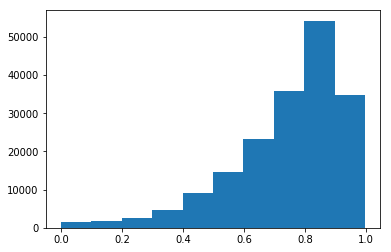

In [13]:
plt.hist(model_pred)
plt.show()

In [14]:
#Confusion matrix for SVC
print("Confusion Matric for CNN: ")
confusion_matrix(y_test,class_pred)

Confusion Matric for CNN: 


array([[  7639,  16637],
       [ 12190, 146072]])

In [6]:
#evaluate the model
from sklearn.model_selection import StratifiedKFold
seed = 7
np.random.seed(seed)

kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=seed)

cvscores = []

for train,test in kfold.split(data, np.array(balanced_labels)):
    model = Sequential()
    model.add(Embedding(20000, 128, input_length=500))#20000 300
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(data[train], np.array(balanced_labels)[train], batch_size=10, epochs=150)
    scores = model.evaluate(data[test], np.array(balanced_labels)[test], verbose=0)
    print(model.metrics_names)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))
  


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/150
  4050/547611 [..............................] - ETA: 1:55:42 - loss: 0.5911 - acc: 0.8553

KeyboardInterrupt: 

# Support Vector Machine

In [4]:
# a list contains each review as a list 
svc_texts = []
svc_labels = []

for i in range(len(balanced_train)):
    svc_texts.append(balanced_train.iloc[i,1])
    svc_labels.append(balanced_train.iloc[i,0])

In [5]:
# data preproccsing and fit Support Vector Machine
t1 = datetime.now()
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3)
svc_classifier = LinearSVC()
Xs = vectorizer.fit_transform(svc_texts)
 
#print(datetime.now() - t1)
#print(Xs.shape)
 
score = cross_val_score(svc_classifier, Xs,svc_labels, cv=2, n_jobs=-1)

#print(datetime.now() - t1)
print(score)
print(sum(score) / len(score))
svc_classifier.fit(Xs, np.array(svc_labels))

[0.81257309 0.80958401]
0.8110785497729885


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [6]:
# split data into training and testing sets
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, np.array(svc_labels), test_size=0.3)

In [7]:
svc_classifier.fit(Xs_train, ys_train)

svc_pred = svc_classifier.predict(Xs_test)

In [21]:
print("Report for Support Vector Machine:")
print(classification_report(ys_test, svc_pred))

print("Accuracy for lr % :",accuracy_score(ys_test, svc_pred)*100)

Report for Support Vector Machine:
              precision    recall  f1-score   support

          -1       0.86      0.97      0.91    121020
           1       0.97      0.88      0.92    158071

   micro avg       0.92      0.92      0.92    279091
   macro avg       0.91      0.92      0.91    279091
weighted avg       0.92      0.92      0.92    279091

('Accuracy for lr % :', 91.53645226825658)


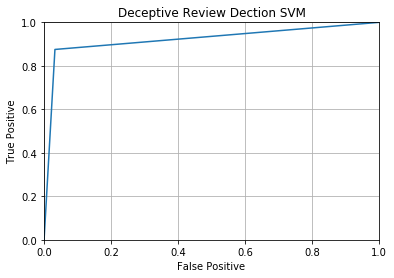

In [22]:
#draw ROC curve
fpr, tpr, thresholds = roc_curve(ys_test,svc_pred)

plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("Deceptive Review Dection SVM")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

/home/drallab/.conda/envs/myenv/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


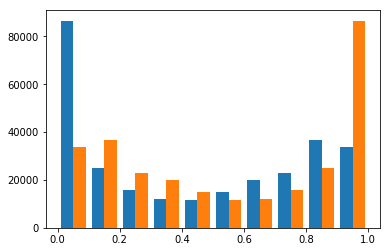

In [10]:
from sklearn.calibration import CalibratedClassifierCV

svc_to_proba = CalibratedClassifierCV(svc_classifier)

svc_to_proba.fit(Xs_train, ys_train)

svc_proba = svc_to_proba.predict_proba(Xs_test)

#probability distribution of support vector machine prediction

plt.hist(svc_proba)

plt.show()

In [11]:
#Confusion matrix for SVC before balance the data
print("Confusion Matric for SVC before balance the data: ")
confusion_matrix(ys_test,svc_pred)

Confusion Matric for SVC before balance the data: 


array([[117095,   3925],
       [ 19696, 138375]])

In [12]:
#Confusion matrix for SVC after balance the data
print("Confusion Matric for SVC after balance the data: ")
confusion_matrix(ys_test,svc_pred)

Confusion Matric for SVC after balance the data: 


array([[117095,   3925],
       [ 19696, 138375]])

In [13]:
#store models to pickle
from sklearn.externals import joblib

def store_lst(text):
    text = text
    new_texts = []
    for i in range(len(text)):
        new_texts.append(text[i])
    return new_texts

joblib.dump(store_lst, "store_lst.pickle")
joblib.dump(vectorizer, "tfidf_vectorizer.pickle")
joblib.dump(svc_classifier, "svc_classifier.pickle")

['svc_classifier.pickle']